<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393/578 Máquinas de Aprendizaje - 2019-1 </h1>

<H3 align='center'> Tarea 2  </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Manipulaciones básicas en numpy
* Preprocesamiento y exploración de datos, creación de datos sinteticos
* Regresión Lineal Regularizada: _Ridge_ y _Lasso_
* SVM y Kernels
* Más _Cross Validation_


**Formalidades**  
* Equipos de trabajo de 2 personas (*Ambos estudiantes deben estar preparados para presentar la tarea el día de la entrega*)
* El entregable debe ser un _Jupyter Notebook_ incluyendo los códigos utilizados, los resultados, los gráficos realizados y comentarios. Debe seguir una estructura similar a un informe (se debe introducir los problemas a trabajar, presentar los resultados y discutirlos). Si lo prefiere puede entregar un _Jupyter Notebook_ por pregunta o uno por toda la tarea, con tal de que todos los entregables esten bien identificados y se encuentren en el mismo repositorio de _Github_.
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el _Jupyter Notebook_ que entregarán. 
* Formato de entrega: envı́o de link del repositorio en _Github_ (en caso de ser repositorio privado, invitar como colaborador al usuario de github "avalderr") al correo electrónico del ayudante (*<alvaro.valderrama.13@sansano.usm.cl>*), en copia al profesor (*<cvalle@inf.utfsm.cl>*). Especificar el siguiente asunto: [INF393/578-2019 Tarea2]
* Fecha de entrega y presentaciones: 31 de Mayo. Hora límite de entrega: 23:00. Cualquier _commit_ luego de la hora límite no será evaluado. Se realizará descuento por atrasos en envío del mail. 

<hr style="height:2px;border:none"/>

La tarea se divide en dos partes:

[1.](#primero) Clasificación de datos no-linealmente separables  
[2.](#tercero) Regularización para regresión   

La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo solo son guias y pueden ser creativos al momento de resolver la tarea. Soluciones creativas o elegantes serán valoradas. También en algunas ocaciones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.
Recuerden intercalar su código con comentarios y con celdas _Markdown_ con los comentarios de la pregunta y con cualquier analisis, fórmula (en $ \LaTeX $) o explicación que les parezca relevante para justificar sus procedimientos. 
Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará mucho la elección en si, en cambio la argumentación detrás de la elección será lo más ponderado.
Si algun modelo se demora demasiado en correr en su maquina, no olvide que puede correr _Jupyter Notebooks_ en _Collab_ de Google, esto puede ser relevante para las maquinas más lentas al momento de realizar exploraciones con _K-folds_ por ejemplo.

Para las siguientes preguntas nos enfocaremos **solo en la versión con ruido de los datos** pues en la práctica no existen datos sin ruido. Probaremos algunos métodos no lineales para ver que tanto logramos mejorar el desempeño en nuestros datos. 

<a id="tercero"></a>
## 2. Regularización para regresión. 

Un problema que podemos encontrar transversalmente a todos los modelos es el problema del _overfitting_. Este problema consiste en un modelo que aprende demasiado bien los datos de ejemplo o entrenamiento, al punto que al momento de ver ejemplos desconocidos o de validación, baja su desempeño respecto a un modelo "menos entrenado". En algunos casos podriamos decir que el modelo "aprende de memoria" los ejemplos, en vez de intentar obtener información generalizable a partir de su entrenamiento. Para el caso de la regresión, una de las aproximaciones más comunes para tratar de mitigar este efecto es el de la regularización. Agregando una penalización a la norma de los parametros de la regresión podemos restringir la eficiencia del modelo al momento de aprender los datos de entrenamiento, incluso forzando dependiendo de la intensidad de la regularización que algunos parametros se vuelvan cero. 

<img src="https://pngimage.net/wp-content/uploads/2018/06/house-for-sale-sign-png-6.png"  style="height:13.9cm;"  />

En esta pregunta utilizaremos nuevamente la base de datos de precios de casas en King County, https://www.kaggle.com/harlfoxem/housesalesprediction, que utilizamos en la Tarea 1. Utilizaremos estos datos ya conocidos y analizados anteriormente para enfocarnos en la regularización para regresión. Exploraremos como varian los distintos errores de predicción y como cambian los valores de los parámetros ajustados por el modelo para distintos valores del coeficiente de regularización, para tratar de entender que ocurre con las distintas regularizaciones y sus diferencias. 

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

#### 2.a Carga y preprocesamiento.
Cargue y preprocese los datos de la misma forma en que lo realizó en la tarea 1, incluyendo estandarizar el _target_. Puede reciclar sus códigos y agregar modificaciones que le parezcan pertinentes.  Para esta parte utilize 0.5 de los datos como _training set_, 0.3 como _validation set_ y 0.2 como _test set_.

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kc_house_data.csv to kc_house_data.csv


In [0]:
data = pd.read_csv("kc_house_data.csv")

In [8]:
data_pre = data
data_pre.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [86]:
data_pre.corr()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
date,1.000000,-0.006039,-0.017680,-0.034466,-0.034411,0.006735,-0.021942,0.002108,-0.001915,-0.050428,-0.040472,-0.027372,-0.020195,-0.000573,-0.024120,-0.033029,-0.007412,-0.031948,0.002975
price,-0.006039,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605567,0.323816,0.054012,0.126434,0.307003,0.021626,0.585379,0.082447
bedrooms,-0.017680,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,0.356967,0.477600,0.303093,0.154178,0.018841,-0.008931,0.129473,0.391638,0.029244
bathrooms,-0.034466,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,0.664983,0.685342,0.283770,0.506019,0.050739,0.024573,0.223042,0.568634,0.087175
sqft_living,-0.034411,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,0.052529,0.240223,0.756420,0.183286
sqft_lot,0.006735,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,0.183512,0.015286,0.053080,0.007644,-0.085683,0.229521,0.144608,0.718557
floors,-0.021942,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,0.523885,-0.245705,0.489319,0.006338,0.049614,0.125419,0.279885,-0.011269
waterfront,0.002108,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,-0.014274,-0.041910,0.086463,0.030703
view,-0.001915,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.006157,-0.078400,0.280439,0.072575
condition,-0.050428,0.036362,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,-0.014941,-0.106500,-0.092824,-0.003406


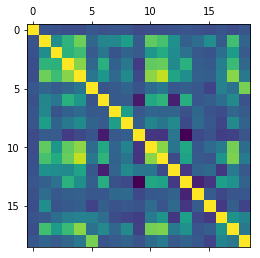

In [87]:
plt.matshow(data_pre.corr())

In [92]:
data_pre.corr()['price'].sort_values() 

date            -0.006039
long             0.021626
condition        0.036362
yr_built         0.054012
sqft_lot15       0.082447
sqft_lot         0.089661
yr_renovated     0.126434
floors           0.256794
waterfront       0.266369
lat              0.307003
bedrooms         0.308350
sqft_basement    0.323816
view             0.397293
bathrooms        0.525138
sqft_living15    0.585379
sqft_above       0.605567
grade            0.667434
sqft_living      0.702035
price            1.000000
Name: price, dtype: float64

#### Transformación de columna 'date'

In [0]:
def to_num(date):
    nums = list(date)
    res = 0
    for i in range(8):
        res = res + int(nums[i])*(10**(7-i))
    return res
data_pre['date'] = data_pre.date.apply(to_num).rank()

In [0]:
data_pre = data_pre.drop(columns=['id','zipcode'])

In [0]:
data_pre_train, data_pre_temp = train_test_split(data_pre, test_size= 0.5)
data_pre_val, data_pre_test = train_test_split(data_pre_temp, test_size= 0.4)

data_x_train = data_pre_train.drop(columns='price')
data_y_train = data_pre_train[['price']]
data_x_val = data_pre_val.drop(columns='price')
data_y_val = data_pre_val[['price']]
data_x_test = data_pre_test.drop(columns='price')
data_y_test = data_pre_test[['price']]


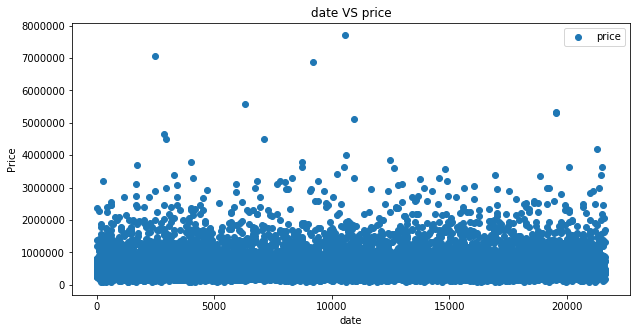

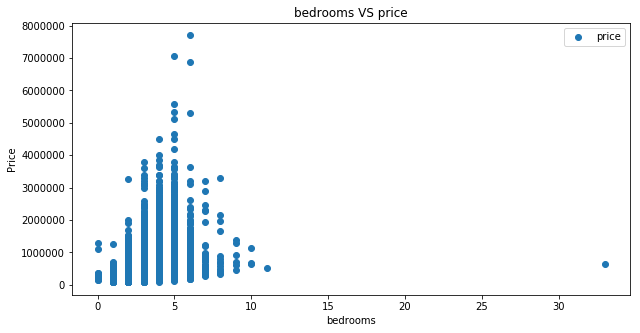

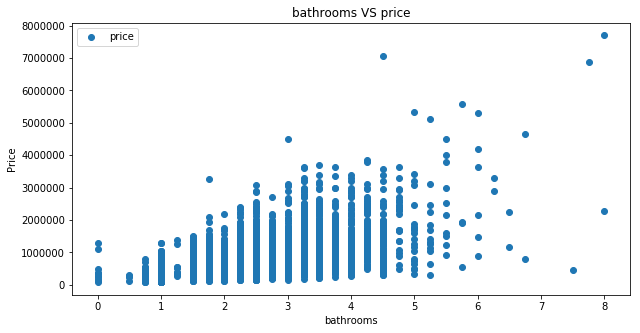

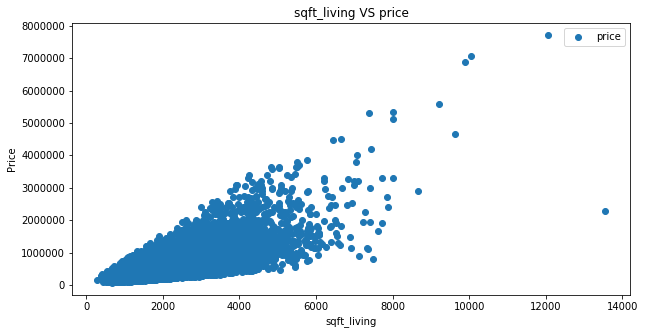

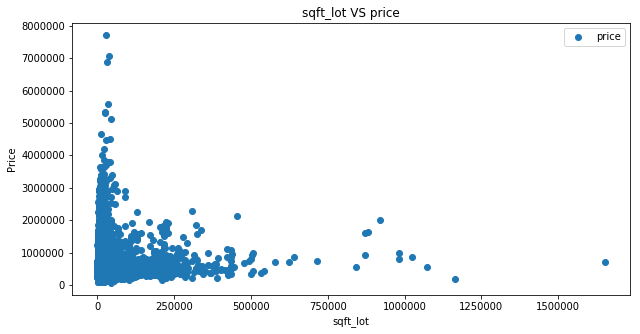

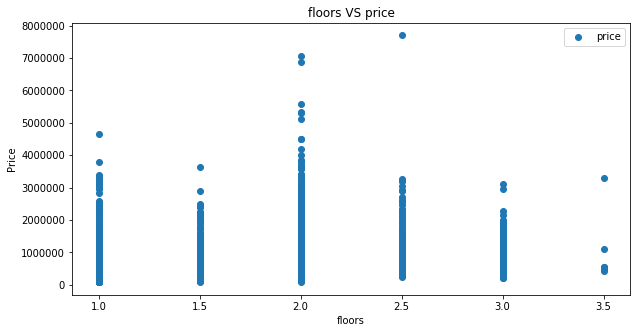

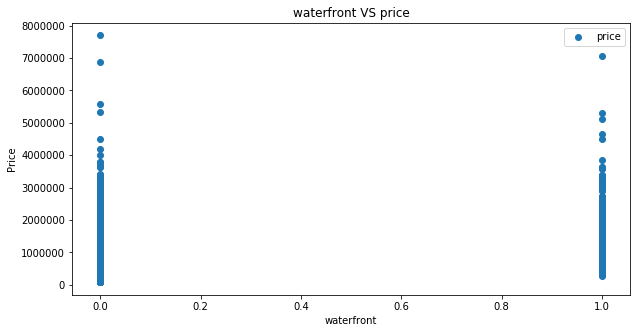

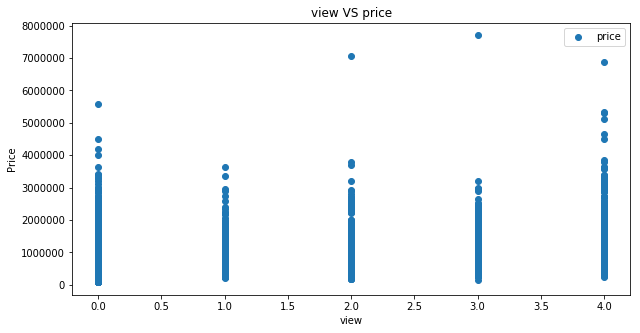

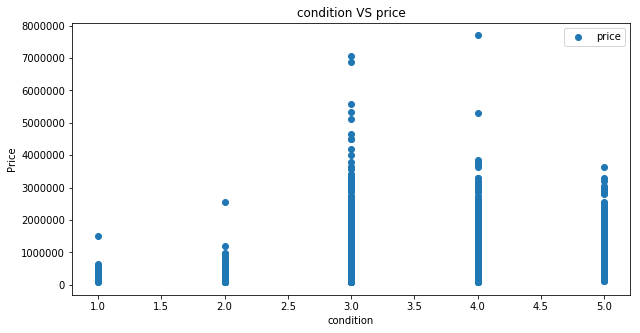

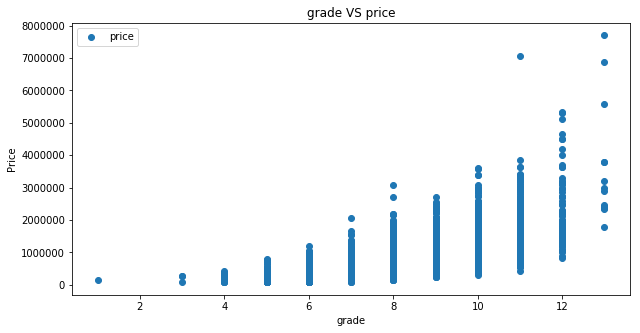

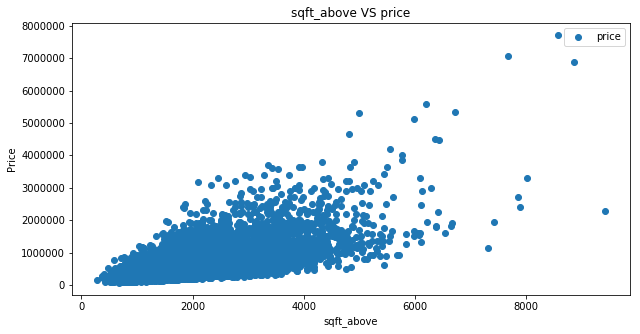

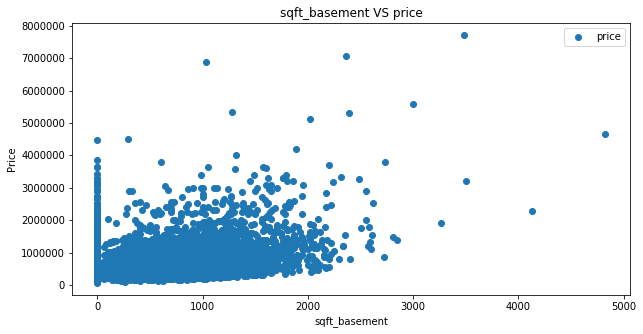

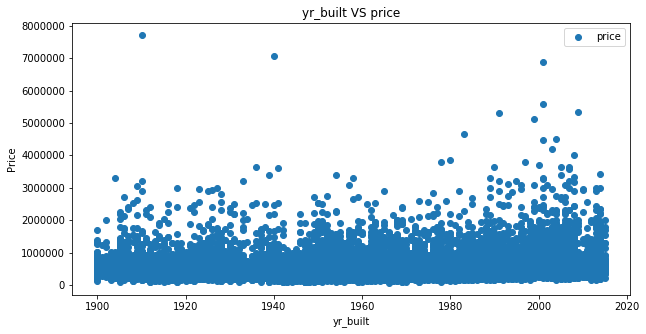

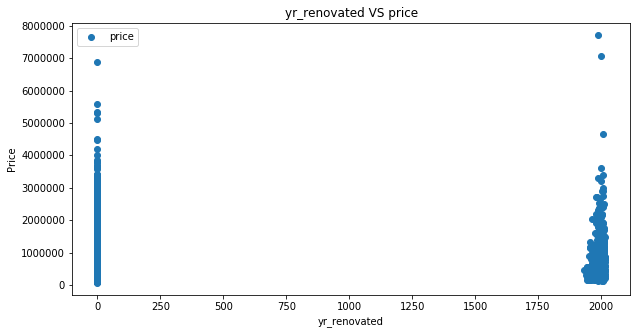

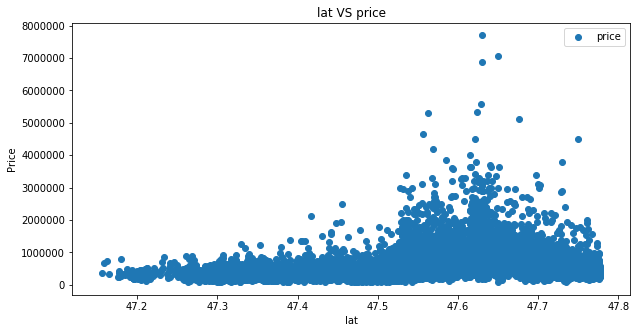

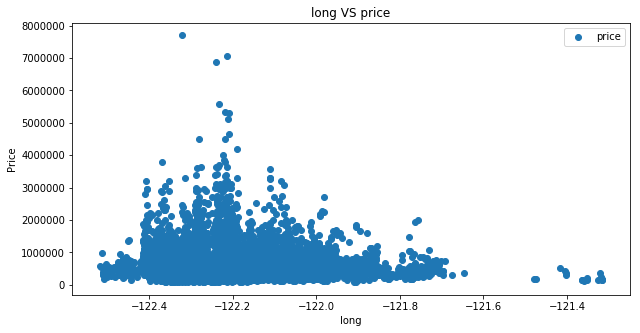

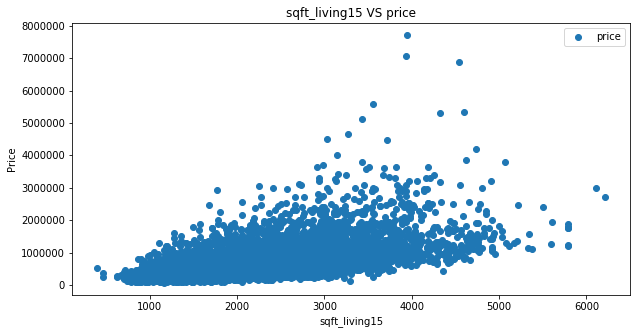

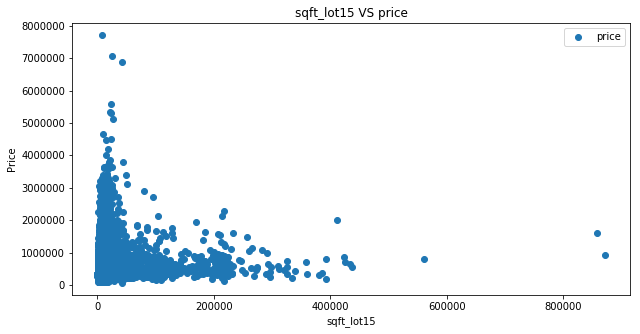

In [8]:
for col in data_pre.columns:
    if col != 'price':
        plt.figure(figsize=(10,5))
        plt.scatter(data_pre[col],data_pre['price'])
        
        plt.xlabel(col)
        plt.ylabel("Price")
        plt.title(col+" VS price")
        plt.legend()
        plt.show()

In [0]:
x_tr, x_val,x_test = data_x_train.copy() ,data_x_val.copy() ,data_x_test.copy()
y_tr, y_val, y_test = data_y_train.copy() ,data_y_val.copy() ,data_y_test.copy()

scaler_x = StandardScaler()
scaler_x.fit(data_x_train)

x_tr[x_tr.columns] = scaler_x.transform(data_x_train) #scaled
x_val[x_val.columns] = scaler_x.transform(data_x_val)
x_test[x_test.columns] = scaler_x.transform(data_x_test)

scaler_y = StandardScaler()
scaler_y.fit(data_y_train.values.reshape(-1,1))

y_tr[y_tr.columns] = scaler_y.transform(data_y_train.values.reshape(-1,1)) 
y_val[y_tr.columns] = scaler_y.transform(data_y_val.values.reshape(-1,1))
y_test[y_tr.columns] = scaler_y.transform(data_y_test.values.reshape(-1,1))


In [10]:
x_tr.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
3903,1.604428,-0.391533,0.169550,-0.022060,-0.198121,0.940928,-0.086363,-0.307402,-0.629137,1.142292,0.015919,-0.074614,-1.060353,-0.208931,0.605183,-1.387630,1.581542,-0.190738
19907,1.368391,1.704012,1.780667,2.085631,-0.143245,0.940928,-0.086363,-0.307402,-0.629137,1.142292,2.687355,-0.655182,1.494978,-0.208931,-0.248567,2.287707,2.486570,-0.223809
17475,-0.832968,0.656240,-0.474896,-0.141568,-0.271493,-0.914994,-0.086363,-0.307402,2.449873,-0.555591,-0.906941,1.376808,-0.685571,-0.208931,0.820414,-0.514561,-0.783209,-0.282602
20975,-0.271356,0.656240,0.813997,1.585869,-0.238374,0.940928,-0.086363,-0.307402,-0.629137,1.142292,2.128782,-0.655182,1.460907,-0.208931,0.408606,1.097799,2.267612,-0.264229
13464,0.203287,-0.391533,0.491774,0.608074,10.628269,0.012967,-0.086363,3.586842,-0.629137,1.991234,1.035922,-0.655182,0.847628,-0.208931,-2.738074,1.238617,-0.710223,20.133888


No handles with labels found to put in legend.


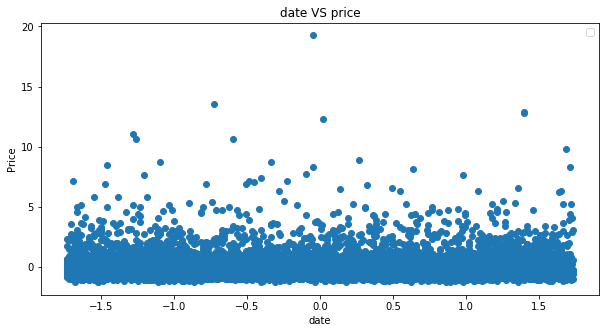

No handles with labels found to put in legend.


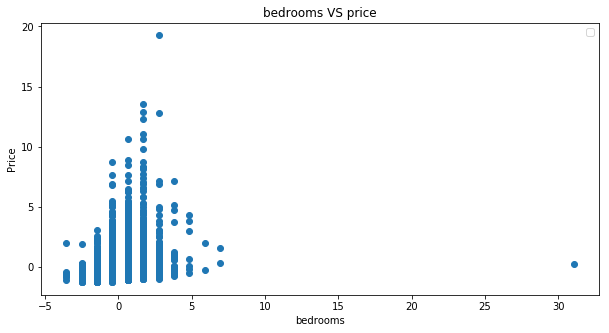

No handles with labels found to put in legend.


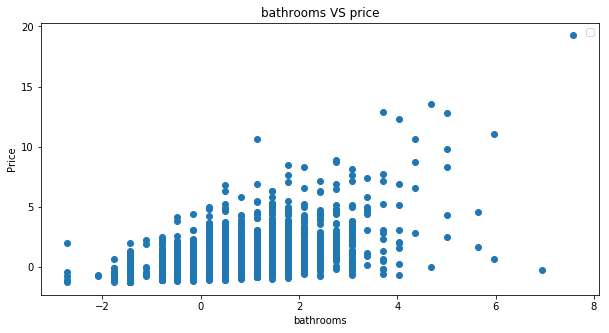

No handles with labels found to put in legend.


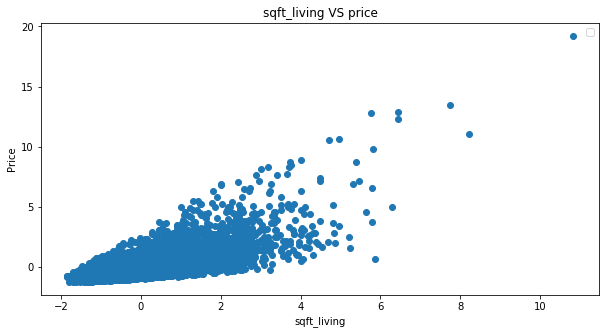

No handles with labels found to put in legend.


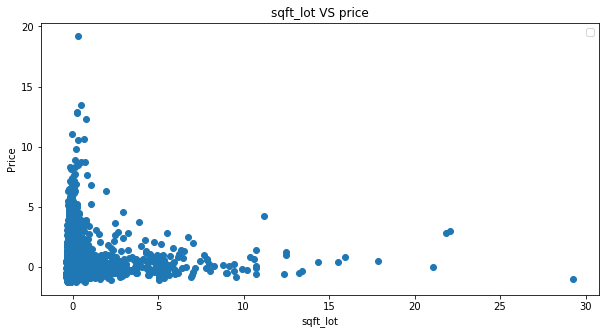

No handles with labels found to put in legend.


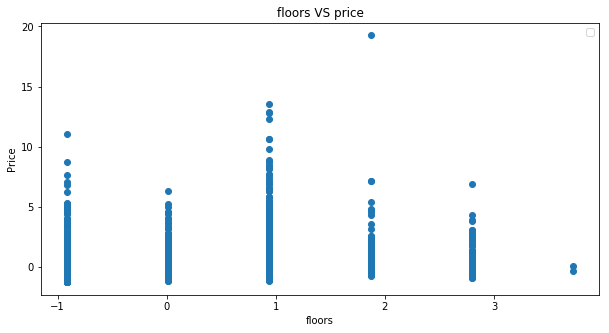

No handles with labels found to put in legend.


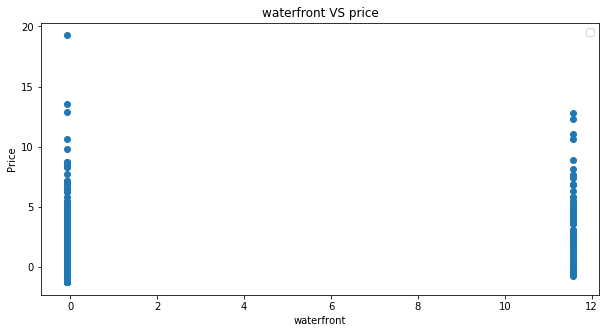

No handles with labels found to put in legend.


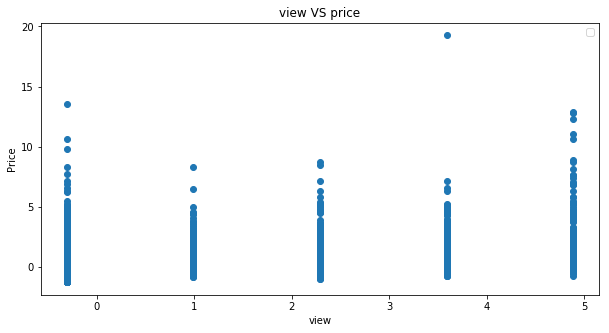

No handles with labels found to put in legend.


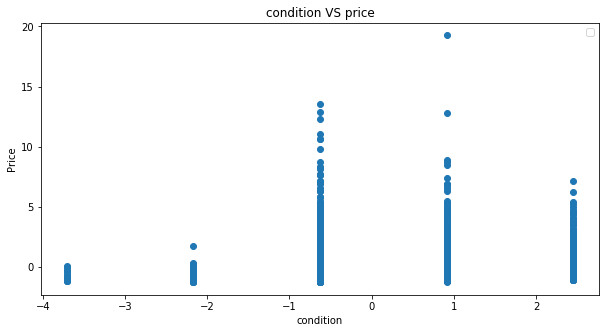

No handles with labels found to put in legend.


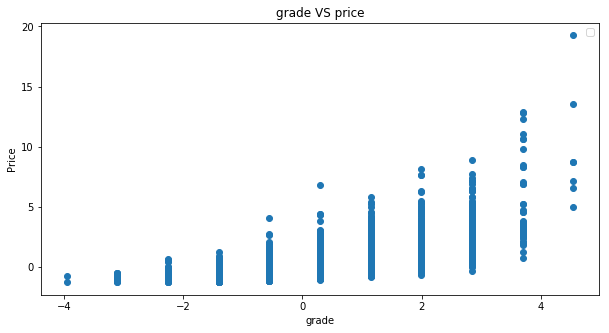

No handles with labels found to put in legend.


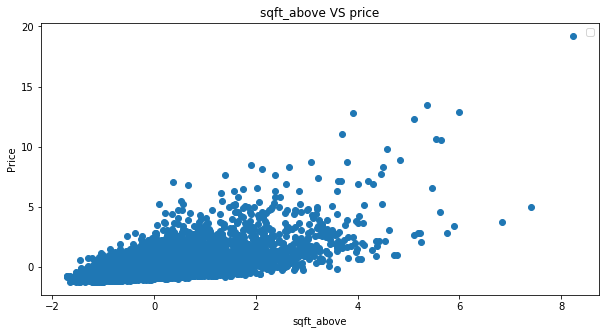

No handles with labels found to put in legend.


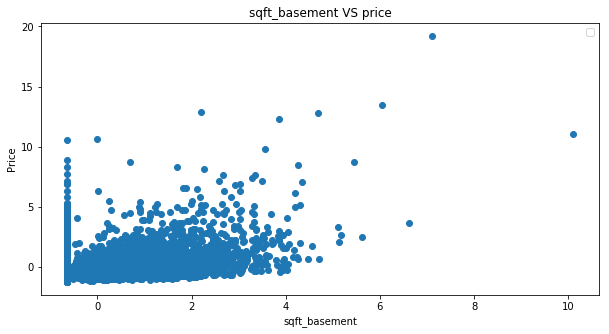

No handles with labels found to put in legend.


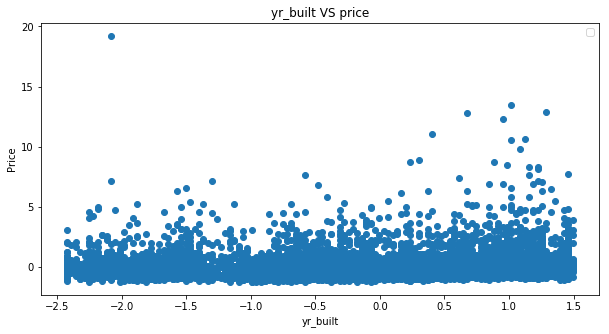

No handles with labels found to put in legend.


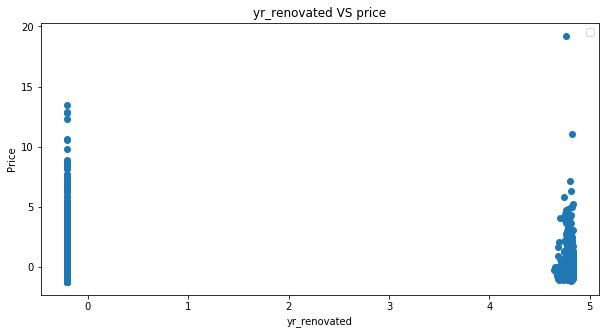

No handles with labels found to put in legend.


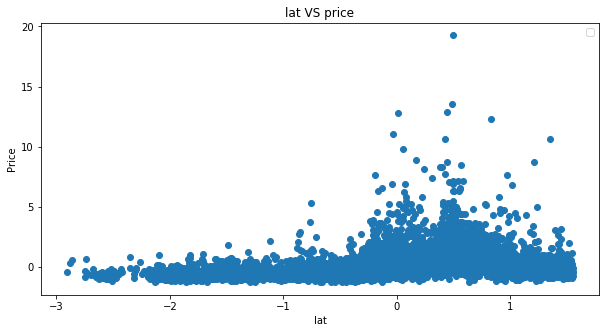

No handles with labels found to put in legend.


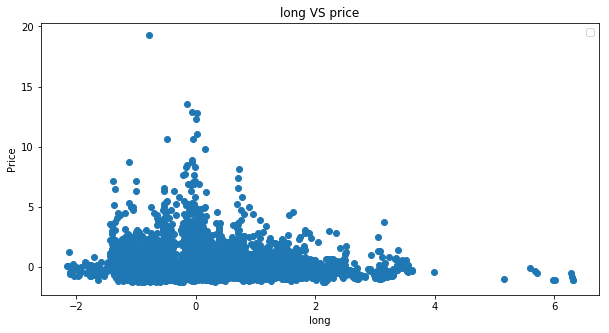

No handles with labels found to put in legend.


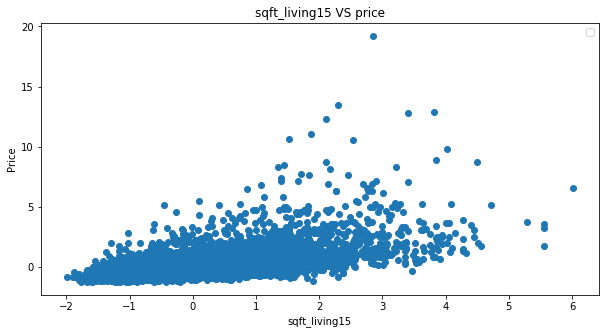

No handles with labels found to put in legend.


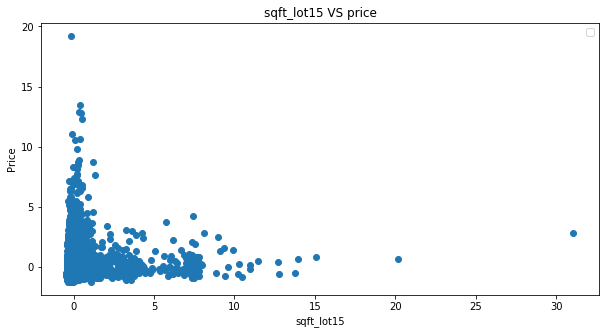

In [11]:
for col in x_tr.columns:
    if col != 'price':
        plt.figure(figsize=(10,5))
        plt.scatter(x_tr[col],y_tr)
        
        plt.xlabel(col)
        plt.ylabel("Price")
        plt.title(col+" VS price")
        plt.legend()
        plt.show()

#### 2.b Modelo sin regularización
Entrene un modelo de regresión lineal no regularizado con los datos preprocesados. Calcule el error cuadrático medio (MSE) del modelo para el conjunto de validación y el de entrenamiento. 

In [0]:
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(x_tr, y_tr)
    
mse = mean_squared_error(model.predict(x_val),y_val)

In [60]:
print(mse)

0.316811185352491


#### 2.c Regularización
Discuta que busca realizar (en términos del ajuste de los parámetros del modelo de regresión lineal) la regularización de _Lasso_. ¿Por qué se habla de penalización en norma $L^1$? Apóyese de ecuaciones. ¿Qué importancia tiene el parámetro de regularización $\lambda$? 

¿Qué diferencia hay entre _Lasso_ y _Ridge_? 

**Comentarios**:  La regularización de Lasso tiene como objetivo penalizar de alguna manera la complejidad de un modelo de regresión lineal, con el fín de ganar capacidad de generalización, y una bajada en el error de prueba del modelo. En que cantidad debe penalizarse el modelo por su complejidad (tamaño de sus parámetros) está dado por el parámetro de regularización $\lambda$. Se hablá de penalización en norma  $L^1$, debido a que el modelo Lasso consiste en sumar al error del modelo de regresión lineal normal, una penalización igual a la normla  $L^1$ de los parámetros del modelo, multiplicado por $\lambda$.
Mientras mas crezca el parámetro $\lambda$, mas se penaliza la complejidad del modelo, por lo tanto el tamaño de los parametros bajará considerablemente a medida que crezca $\lambda$ para poder mantener el error bajo.

La diferencia entre Lasso y Ridge, es que, si bien actuan de manera muy similar, usan normas diferentes,  $L^1$ y  $L^2$ respectivamente. Esto hace que se comporten de manera notoriamente distinta. En Lasso, los parámetros del modelo tienden a anularse completamente a medida que aumenta $\lambda$, y manera mas rápida que en Ridge. Mientras que en Ridge, la caida de estos parámetros es mas lenta, se requiere un aumento mucho mayor de $\lambda$ para uqe esto suceda, y los parámetros nunca llegan a ser complemtamente 0. Es por esto que Lasso funciona mejor en casos en los que se tienen muchas variables y pocas de estás útiles para predecir, mientras que Ridge se comporta mejor con modelos con pocas variables pero mas significativas.


#### 2.d Influencia sobre el error
Grafique como varia el error de entrenamiento y el error de validación a medida se cambia el valor del parámetro $\lambda$. Para esto debe entrenar un modelo para cada uno de los parámetros que considerará en el gráfico y calcular el MSE para ambos sets. Comente sobre lo que ve en el gráfico y si lo encuentra pertinente puede calcular en más detalle alguna zona que le parezca interesante. 
Es conveniente entrenar primero unos cuantos modelos con valores de $\lambda$ escogidos manualmente para saber mejor en que intervalo resulta pertinente calcular estos valores (para _Ridge_ se necesitan valores más altos en este caso para ver la influencia sobre el error).

Note que el parámetro $\lambda$ es sensible a la escala de los datos, por lo cual deberá estudiar valores distintos dependiendo de si estandarizó el _target_ o no. 

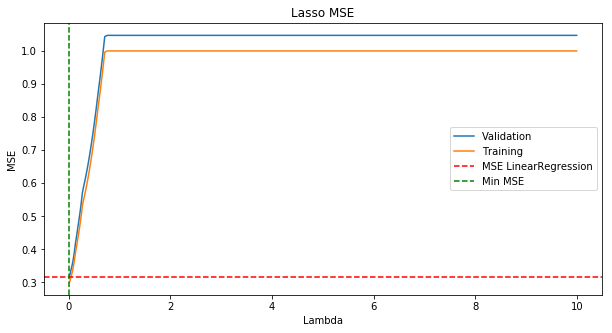

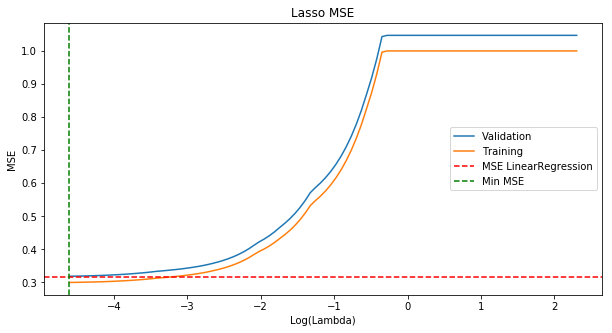

In [73]:
from sklearn.metrics import mean_squared_error

# for example:
MSE_val_lasso = []
MSE_tr_lasso = []
space = pd.np.logspace(-2,1,100)
min = space[0]
max = space[-1]
min_error_val = 1000
min_error_val_x = 0
for lambd in space:
    model_lasso = Lasso(alpha=lambd)
    model_lasso.fit(x_tr, y_tr)
    mse_val = mean_squared_error(model_lasso.predict(x_val), y_val)
    mse_tr = mean_squared_error(model_lasso.predict(x_tr), y_tr)
    
    if mse_val < min_error_val:
        min_error_val = mse_val
        min_error_val_x = lambd
    
    MSE_val_lasso.append(mse_val)
    MSE_tr_lasso.append(mse_tr)
    
# GRAFICO
plt.figure(figsize=(10,5))    
plt.plot( space, MSE_val_lasso, label="Validation") 
plt.plot( space, MSE_tr_lasso, label="Training") 
plt.axhline(y=mse, label='MSE LinearRegression', color='red', linestyle='--')
plt.axvline(x=min_error_val_x, label='Min MSE', color='green', linestyle='--')
        
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.title("Lasso MSE")
plt.legend()
plt.show()

# GRAFICO LOGARITMO

plt.figure(figsize=(10,5))

plt.plot( np.log(space), MSE_val_lasso, label="Validation") 
plt.plot( np.log(space), MSE_tr_lasso, label="Training") 
plt.axhline(y=mse, label='MSE LinearRegression', color='red', linestyle='--')
plt.axvline(x=np.log(min_error_val_x), label='Min MSE', color='green', linestyle='--')

plt.xlabel("Log(Lambda)")
plt.ylabel("MSE")
plt.title("Lasso MSE")
plt.legend()
plt.show()

In [74]:
print("Minimo MSE Val: ", min_error_val, "   Lambda: ", min_error_val_x)

Minimo MSE Val:  0.31883301581454326    Lambda:  0.01


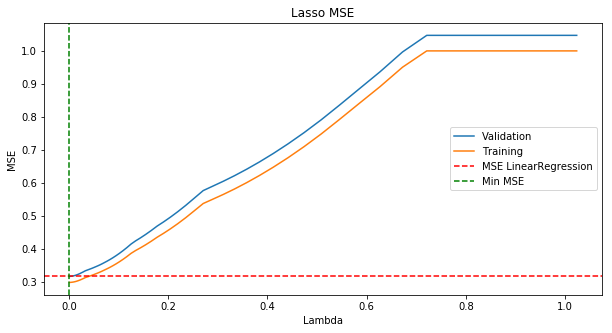

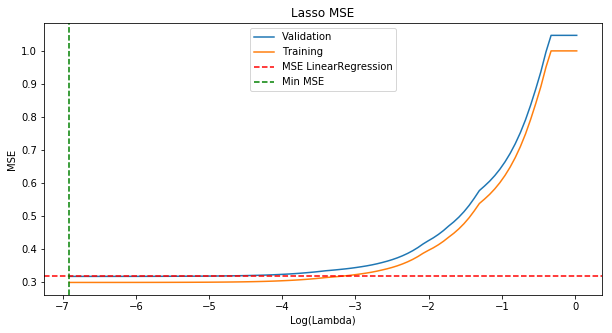

In [75]:
from sklearn.metrics import mean_squared_error

# for example:
MSE_val_lasso = []
MSE_tr_lasso = []
space = pd.np.logspace(-3,0.01,100)
min = space[0]
max = space[-1]
min_error_val = 1000
min_error_val_x = 0
for lambd in space:
    model_lasso = Lasso(alpha=lambd)
    model_lasso.fit(x_tr, y_tr)
    mse_val = mean_squared_error(model_lasso.predict(x_val), y_val)
    mse_tr = mean_squared_error(model_lasso.predict(x_tr), y_tr)
    
    if mse_val < min_error_val:
        min_error_val = mse_val
        min_error_val_x = lambd
    
    MSE_val_lasso.append(mse_val)
    MSE_tr_lasso.append(mse_tr)
    
# GRAFICO
plt.figure(figsize=(10,5))    
plt.plot( space, MSE_val_lasso, label="Validation") 
plt.plot( space, MSE_tr_lasso, label="Training") 
plt.axhline(y=mse, label='MSE LinearRegression', color='red', linestyle='--')
plt.axvline(x=min_error_val_x, label='Min MSE', color='green', linestyle='--')
        
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.title("Lasso MSE")
plt.legend()
plt.show()

# GRAFICO LOGARITMO

plt.figure(figsize=(10,5))

plt.plot( np.log(space), MSE_val_lasso, label="Validation") 
plt.plot( np.log(space), MSE_tr_lasso, label="Training") 
plt.axhline(y=mse, label='MSE LinearRegression', color='red', linestyle='--')
plt.axvline(x=np.log(min_error_val_x), label='Min MSE', color='green', linestyle='--')

plt.xlabel("Log(Lambda)")
plt.ylabel("MSE")
plt.title("Lasso MSE")
plt.legend()
plt.show()

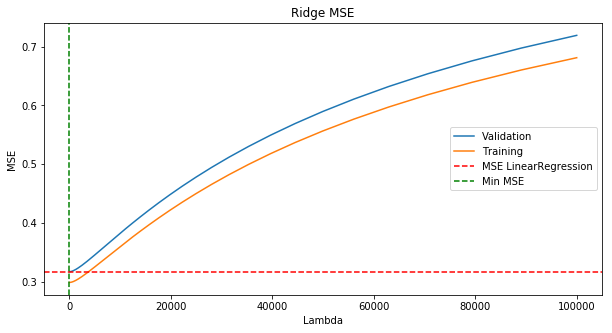

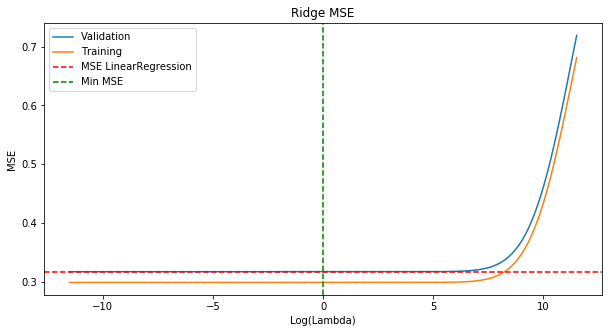

In [80]:

MSE_val_ridge = []
MSE_tr_ridge = []
space = pd.np.logspace(-5,5,200)
min_error_val = 1000000
min_error_val_x = 0
for lambd in space:
    model_ridge = Ridge(alpha=lambd)
    model_ridge.fit(x_tr, y_tr)
    mse_val = mean_squared_error(model_ridge.predict(x_val), y_val)
    mse_tr = mean_squared_error(model_ridge.predict(x_tr), y_tr)
   
    if mse_val < min_error_val:
        min_error_val = mse_val
        min_error_val_x = lambd
    
    MSE_val_ridge.append(mse_val)
    MSE_tr_ridge.append(mse_tr)
    
plt.figure(figsize=(10,5))    
plt.plot( space, MSE_val_ridge, label="Validation") 
plt.plot( space, MSE_tr_ridge, label="Training") 
plt.axhline(y=mse, label='MSE LinearRegression', color='red', linestyle='--')
plt.axvline(x=min_error_val_x, label='Min MSE', color='green', linestyle='--')
        
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.title("Ridge MSE")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))    
plt.plot( np.log(space), MSE_val_ridge, label="Validation") 
plt.plot( np.log(space), MSE_tr_ridge, label="Training") 
plt.axhline(y=mse, label='MSE LinearRegression', color='red', linestyle='--')
plt.axvline(x=min_error_val_x, label='Min MSE', color='green', linestyle='--')
        
plt.xlabel("Log(Lambda)")
plt.ylabel("MSE")
plt.title("Ridge MSE")
plt.legend()
plt.show()

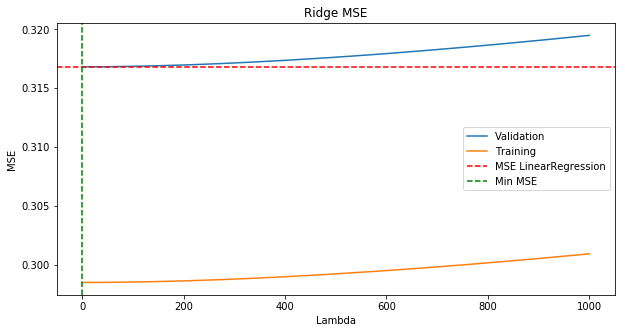

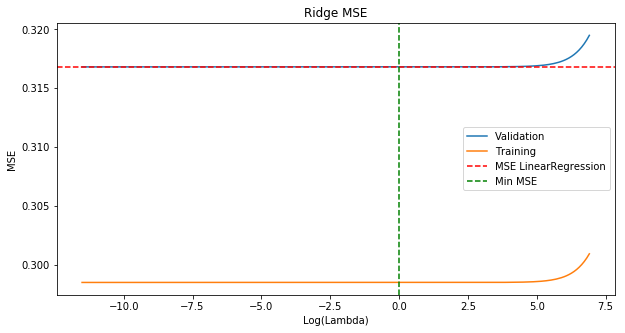

In [81]:
MSE_val_ridge = []
MSE_tr_ridge = []
space = pd.np.logspace(-5,3,200)
min_error_val = 1000000
min_error_val_x = 0
for lambd in space:
    model_ridge = Ridge(alpha=lambd)
    model_ridge.fit(x_tr, y_tr)
    mse_val = mean_squared_error(model_ridge.predict(x_val), y_val)
    mse_tr = mean_squared_error(model_ridge.predict(x_tr), y_tr)
   
    if mse_val < min_error_val:
        min_error_val = mse_val
        min_error_val_x = lambd
    
    MSE_val_ridge.append(mse_val)
    MSE_tr_ridge.append(mse_tr)
    
plt.figure(figsize=(10,5))    
plt.plot( space, MSE_val_ridge, label="Validation") 
plt.plot( space, MSE_tr_ridge, label="Training") 
plt.axhline(y=mse, label='MSE LinearRegression', color='red', linestyle='--')
plt.axvline(x=min_error_val_x, label='Min MSE', color='green', linestyle='--')
        
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.title("Ridge MSE")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))    
plt.plot( np.log(space), MSE_val_ridge, label="Validation") 
plt.plot( np.log(space), MSE_tr_ridge, label="Training") 
plt.axhline(y=mse, label='MSE LinearRegression', color='red', linestyle='--')
plt.axvline(x=min_error_val_x, label='Min MSE', color='green', linestyle='--')
        
plt.xlabel("Log(Lambda)")
plt.ylabel("MSE")
plt.title("Ridge MSE")
plt.legend()
plt.show()

In [85]:
print("Minimo MSE Val: ", min_error_val, "   Lambda: ", min_error_val_x)

Minimo MSE Val:  0.3168111853535408    Lambda:  1e-05


**Comentarios**: Podemos apreciar que en ambos modelos el error va aumentando a medida que aumenta $\lambda$. En Lasso de manera mucho mas rápida que en Ridge. Se aprecia que el mínimo error alcanzado está al inicio de los valores probados para lambda, osea en el valor msa pequeño, en ambos modelos. Vemos que el error nunca logró bajar mas de lo que se había logrado en la pregunta B. El error de training en ambos casos en menor que el de validación, pero varía de igual manera a medida que varía $\lambda$.

#### 2.e Influencia sobre los coeficientes
Grafique ahora como se comporta el valor de los coeficientes del modelo lineal en el modelo entrenado a medida crece $\lambda$, tanto para _Lasso_ como para _Ridge_. Para esto entrene un modelo para cada valor de $\lambda$ y guarde sus coeficientes, como propone el princio de código a continuación. Debe explorar valores de $\lambda$ donde todos los coeficientes sean no nulos hasta valores donde todos los coeficientes se anulan. 

¿Qué diferencias ve entre _Ridge_ y _Lasso_? ¿Coincide este comportamiento con lo que esperaría teóricamente de cada uno de los modelos? 

¿Podemos utilizar estos gráficos para discutir sobre la cantidad de información que entrega cada uno de los atributos para predecir el _target_? ¿Cual de ambos (_Ridge_ o _Lasso_) le parece mejor para este tipo de discución? Compare lo que muestran estos gráficos con alguna otra aproximación para medir la significancia de cada atributo (como correlación o _mutual information_ por ejemplo) y discuta. 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.20189141179344, tolerance: 1.0806000000000004
  positive)


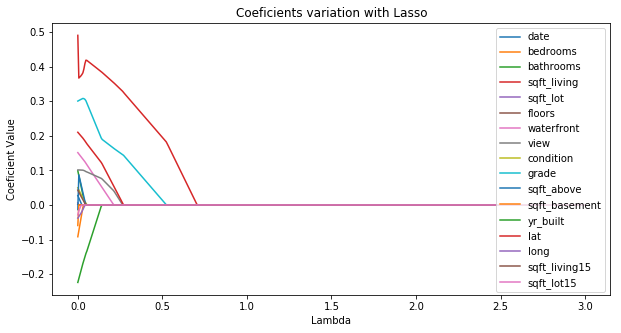

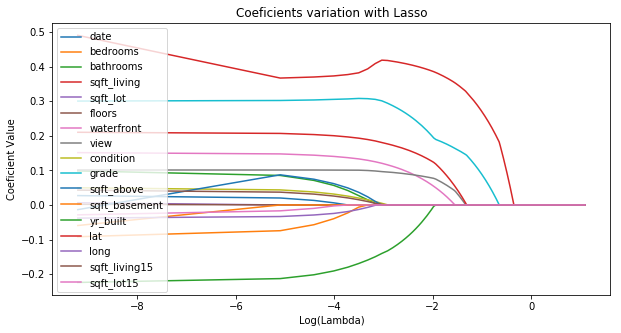

In [34]:
space = pd.np.linspace(0.0001,3,500) 
# should be fine for Lasso, for Ridge try space = pd.np.logspace(0,10,50) and plot x on a logarithmic
# scale (you can simply do np.linspace(0,10,50) when setting x values for the plot)
coefs_lasso = []
for l in space:
    model_lasso = Lasso(alpha=l)
    model_lasso.fit(x_tr, y_tr)
    coefs_lasso.append(model_lasso.coef_)

x_cols = x_tr.columns

plt.figure(figsize=(10,5))   
for y_arr, label in zip(pd.np.squeeze(coefs_lasso).T, x_cols):
    plt.plot(space, y_arr, label=label)
    
plt.xlabel("Lambda")
plt.ylabel("Coeficient Value")
plt.title("Coeficients variation with Lasso")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))   
for y_arr, label in zip(pd.np.squeeze(coefs_lasso).T, x_cols):
    plt.plot(np.log(space), y_arr, label=label)
    
plt.xlabel("Log(Lambda)")
plt.ylabel("Coeficient Value")
plt.title("Coeficients variation with Lasso")
plt.legend()
plt.show()

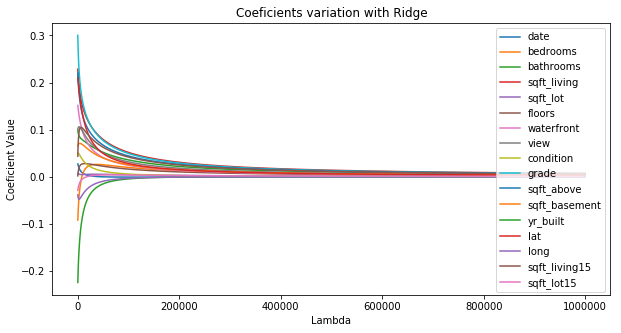

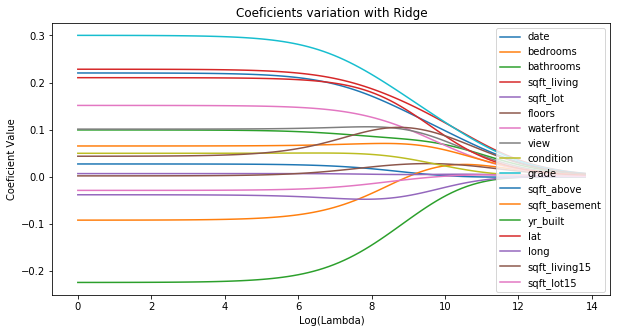

In [32]:
space = pd.np.logspace(0,6,100) 
# should be fine for Lasso, for Ridge try space = pd.np.logspace(0,10,50) and plot x on a logarithmic
# scale (you can simply do np.linspace(0,10,50) when setting x values for the plot)
coefs = []
for l in space:
    model_ridge = Ridge(alpha=l)
    model_ridge.fit(x_tr, y_tr)
    coefs.append(model_ridge.coef_)

x_cols = x_tr.columns

plt.figure(figsize=(10,5))   
for y_arr, label in zip(pd.np.squeeze(coefs).T, x_cols):
    plt.plot(space, y_arr, label=label)
    
plt.xlabel("Lambda")
plt.ylabel("Coeficient Value")
plt.title("Coeficients variation with Ridge")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))   
for y_arr, label in zip(pd.np.squeeze(coefs).T, x_cols):
    plt.plot(np.log(space), y_arr, label=label)
    
plt.xlabel("Log(Lambda)")
plt.ylabel("Coeficient Value")
plt.title("Coeficients variation with Ridge")
plt.legend()
plt.show()

In [13]:
from sklearn.feature_selection import mutual_info_regression
MI = list(zip(mutual_info_regression(x_tr, y_tr),x_tr.columns))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


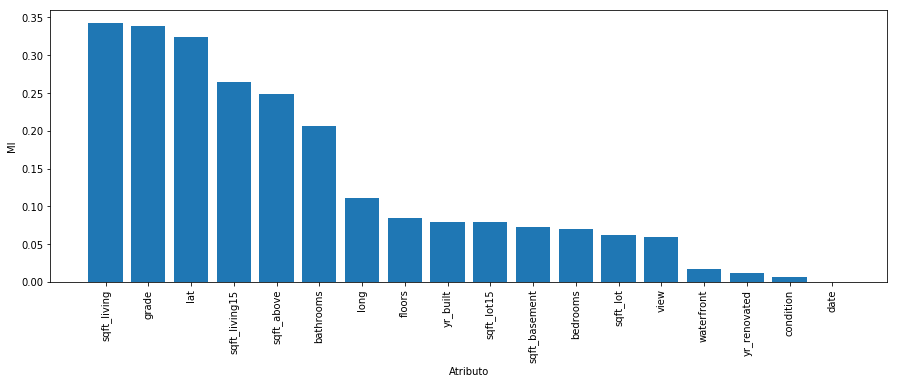

In [14]:
MI.sort(reverse=True)

plt.figure(figsize=(15,5))
plt.bar(list(map(lambda x: x[1], MI)), list(map(lambda x: x[0], MI)))
plt.plot()

plt.xticks(rotation=90)
plt.ylabel("MI")
plt.xlabel("Atributo")

plt.show()

**Comentarios**: Se puede apreciar que los parametros del modelo decaen de manera muy distinta en Lasso y Ridge a medida que avanza $\lambda$. En lasso es una caída mucho más abrupta de los parametros, mientras que en Ridge es una caída mas lenta y suave. En ambos casos se aprecia que hay parámetros que son mas relevantes, debido a que se anulan mas tarde que los otros, y parten con valores mayores. Comparando con mutual information, tiene sentido ya que hay variables que están en el top de mutual information, y son las uqe mas tardan en decaer, que serían sqft_living y grade. Cosa que tiene mucho sentido.




#### 2.f K-_fold_ sobre $\lambda$
Realice 5-_fold_ o 10-_fold_ sobre el parámetro de regularización $\lambda$, ya sea para _Lasso_ o _Ridge_. Explore a lo menos 20 valores distintos de $\lambda$ en un intervalo relevante luego de lo aprendido en las preguntas anteriores. Utilice MSE como el error a minimizar. 

Compare el error de entrenamiento y de validación para este modelo respecto al modelo lineal sin regularización entrenado inicialmente. ¿En su opinión se alcanza a apreciar el fenomeno de _overfitting_ para este conjunto de datos y el modelo logístico? 

In [82]:
from sklearn.model_selection import KFold

X_tr_kfold = x_tr.append(x_val)
y_tr_kfold = y_tr.append(y_val)
kf = KFold(n_splits=5)
print(kf)


KFold(n_splits=5, random_state=None, shuffle=False)


In [0]:

lambda_values = np.logspace(0,3,20)
lambda_scores = list()
lambda_error_lists = list()
for lambda_i in lambda_values:
    fold_scores = list()

    for train_index, test_index in kf.split(X_tr_kfold):       
        X_train_cross, X_test_cross = X_tr_kfold.iloc[train_index,:], X_tr_kfold.iloc[test_index,:]
        y_train_cross, y_test_cross = y_tr_kfold.iloc[train_index,:], y_tr_kfold.iloc[test_index,:]

        # entrene el modelo y guarde su score
        model = Ridge(alpha=lambda_i)
        model.fit(X_train_cross, y_train_cross)
        y_pred = model.predict(X_test_cross)
        error = mean_squared_error(y_pred, y_test_cross)
        fold_scores.append(error)
    lambda_scores.append((sum(fold_scores)/len(fold_scores)))
    lambda_error_lists.append(fold_scores)

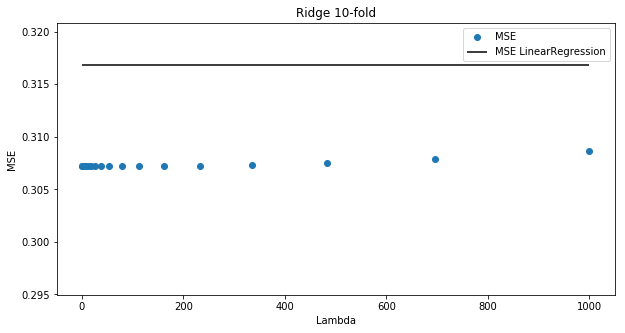

In [84]:
plt.figure(figsize=(10,5))    
plt.scatter( lambda_values,lambda_scores, label="MSE") 
mini = lambda_values[0]
maxi = lambda_values[-1]
plt.hlines(mse, mini, maxi, label='MSE LinearRegression')
        
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.title("Ridge 10-fold")
plt.legend()
plt.show()

**Comentario**:  Se aprecia que los errores promedio al hacer 10-fold bajan en comparación a cuando solo se media una vez el error del training set. Ahora si se el error baja mas de apreciado en la regresión normal sin regularización, y podemos apreciar para el intervalo probado que el menor valor esta para los valores mas cercanos a 0. En nuestra opinión **no se alcanza a apreciar overfitting** para los modelos de esta tarea. Se esperaría que si el modelo estuviera sobreajustado, la curva de error bajara considerablemente en comparación a el modelo sin regularización, para ciertos $\lambda$.

#### 2.g _Grid search_ para SVM (Opcional)

Para terminar, comparemos el desempeño de los métodos lineales con un método no lineal, las SVM. Para esto buscaremos ajustar los hiperparámetros más relevantes del modelo, en este caso el parámetro `C` y `epsilon`, la penalización y el margen de holgura. Comente sobre la significancia de estos parámetros y su influencia sobre la máquina. Luego realice una busqueda en un mallado de estos parámetros, evaluando el _score_ (coeficiente de determinación) o MSE o ambos.

*Nota*: Entrenar una SVM toma mucho más tiempo que las regresiones lineales, por lo cual es recomendable probar primero su código en un número reducido de puntos y luego entrenar todos los modelos asegurandose de guardar bien los resultados. Si su maquina es muy lenta es incluso recomendable que esta parte la realice en _Collab_ de Google si desea explorar un número relevante de puntos. El mallado propuesto en el código es de referencia y puede elegirlo o construirlo como usted estime más conveniente. 

De todos los modelos entrenados, ¿Cuál es el mejor? ¿Cómo se compara el desempeño de este modelo con el mejor modelo lineal encontrado por usted? Adjunte gráficos que le parezcan relevantes. 

In [0]:
from sklearn.svm import SVR

Cs, epsilons = pd.np.meshgrid([i for i in range(1,10)],[i/20 for i in range(1,21)])
for for C, epsilon in zip(Cs.reshape((-1,1)), epsilons.reshape((-1,1))):
    sv = SVR(C=C, epsilon=epsilon)
    
    # fit and save the scores for each one